In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import numpy as np
import torch
import clip
from PIL import Image
import faiss
from tqdm import tqdm

ModuleNotFoundError: No module named 'clip'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
# Load CLIP model
model, preprocess = clip.load("RN50", device=device)

100%|███████████████████████████████████████| 244M/244M [00:04<00:00, 55.7MiB/s]


In [22]:
clip.available_models()


['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [24]:
# Path to MVTec bottle category
base_path = "/kaggle/input/mvtec-ad/bottle"


In [25]:
# Load training normal images
train_dir = os.path.join(base_path, "train", "good")
train_images = [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith(".png") or f.endswith(".jpg")]


In [26]:
# Encode training images using CLIP
train_features = []
for img_path in tqdm(train_images, desc="Encoding train images"):
    img = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        features = model.encode_image(img).cpu().numpy()
        # features = model.visual_model.forward(img).cpu().numpy()  # CLIP's ViT backbone

    train_features.append(features[0])

train_features = np.stack(train_features).astype("float32")

Encoding train images: 100%|██████████| 209/209 [00:36<00:00,  5.66it/s]


In [27]:
train_features.shape

(209, 1024)

In [28]:
# Normalize features (important for cosine similarity)
train_features /= np.linalg.norm(train_features, axis=1, keepdims=True)

In [29]:

# Create FAISS index (cosine similarity = dot product since vectors are normalized)
index = faiss.IndexFlatIP(train_features.shape[1])
index.add(train_features)

In [30]:
# Test images
test_root = os.path.join(base_path, "test")
classes = os.listdir(test_root)
results = []

for cls in classes:
    cls_dir = os.path.join(test_root, cls)
    image_paths = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.endswith(".png") or f.endswith(".jpg")]
    
    for img_path in image_paths:
        img = preprocess(Image.open(img_path).convert("RGB")).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = model.encode_image(img).cpu().numpy()
        feat /= np.linalg.norm(feat, axis=1, keepdims=True)
        sim, idx = index.search(feat.astype("float32"), k=1)
        score = 1 - sim[0][0]  # 1 - similarity = anomaly score
        results.append((img_path, cls, score))

# Print top 10 most anomalous
results.sort(key=lambda x: x[2], reverse=True)
print("\nTop 10 likely defects:")
for path, label, score in results[:10]:
    print(f"{path} | Label: {label} | Anomaly score: {score:.4f}")


Top 10 likely defects:
/kaggle/input/mvtec-ad/bottle/test/contamination/005.png | Label: contamination | Anomaly score: 0.0911
/kaggle/input/mvtec-ad/bottle/test/contamination/007.png | Label: contamination | Anomaly score: 0.0791
/kaggle/input/mvtec-ad/bottle/test/broken_large/003.png | Label: broken_large | Anomaly score: 0.0613
/kaggle/input/mvtec-ad/bottle/test/broken_large/008.png | Label: broken_large | Anomaly score: 0.0610
/kaggle/input/mvtec-ad/bottle/test/contamination/017.png | Label: contamination | Anomaly score: 0.0587
/kaggle/input/mvtec-ad/bottle/test/broken_large/013.png | Label: broken_large | Anomaly score: 0.0508
/kaggle/input/mvtec-ad/bottle/test/broken_large/002.png | Label: broken_large | Anomaly score: 0.0485
/kaggle/input/mvtec-ad/bottle/test/contamination/008.png | Label: contamination | Anomaly score: 0.0451
/kaggle/input/mvtec-ad/bottle/test/contamination/006.png | Label: contamination | Anomaly score: 0.0445
/kaggle/input/mvtec-ad/bottle/test/contamination

In [31]:
from PIL import Image
import numpy as np
import torch

# Define image path (can be any test image)
test_img_path = "/kaggle/input/mvtec-ad/bottle/test/broken_large/002.png"

# Load and preprocess the image
img = preprocess(Image.open(test_img_path).convert("RGB")).unsqueeze(0).to(device)

# Get CLIP features
with torch.no_grad():
    feat = model.encode_image(img).cpu().numpy()

# Normalize feature vector
feat /= np.linalg.norm(feat, axis=1, keepdims=True)

# Search in FAISS index
sim, idx = index.search(feat.astype("float32"), k=1)

# Compute anomaly score
anomaly_score = 1 - sim[0][0]

# Output result
print(f"Inference on image: {test_img_path}")
print(f"Nearest similarity to normal: {sim[0][0]:.4f}")
print(f"Anomaly score: {anomaly_score:.4f}")

# Optional: Decide if it's anomalous using a threshold
threshold = 0.3  # You can tune this based on ROC or visual inspection
label = "DEFECT" if anomaly_score > threshold else "NORMAL"
print(f"Prediction: {label}")


Inference on image: /kaggle/input/mvtec-ad/bottle/test/broken_large/002.png
Nearest similarity to normal: 0.9515
Anomaly score: 0.0485
Prediction: NORMAL


CLIP is bs! I don't know how to use. Let's so typical AD

In [5]:
!pip install torch torchvision timm numpy scikit-learn tqdm matplotlib


In [6]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
from tqdm import tqdm

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained model
model = models.resnet18(pretrained=True)
model = model.to(device)
model.eval()

# Define transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Function to extract features
def extract_features(image_paths):
    features = []
    for img_path in tqdm(image_paths):
        img = Image.open(img_path).convert('RGB')
        img = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feat = model(img)
        features.append(feat.cpu().numpy().squeeze())
    return np.array(features)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 127MB/s] 


In [34]:
from sklearn.covariance import EmpiricalCovariance

# Assume 'train_features' is the array of features from training images
mean_vector = np.mean(train_features, axis=0)
cov_matrix = EmpiricalCovariance().fit(train_features)

# Save the mean and covariance for later use
np.save('mean_vector.npy', mean_vector)
np.save('cov_matrix.npy', cov_matrix.covariance_)


In [36]:
# Set paths
base_path = "/kaggle/input/mvtec-ad/bottle"  # Change as needed
train_dir = os.path.join(base_path, "train", "good")
test_root = os.path.join(base_path, "test")

# List image paths
train_image_paths = [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith(".png") or f.endswith(".jpg")]

test_image_paths = []
for cls in os.listdir(test_root):
    cls_dir = os.path.join(test_root, cls)
    for f in os.listdir(cls_dir):
        if f.endswith(".png") or f.endswith(".jpg"):
            test_image_paths.append(os.path.join(cls_dir, f))

In [37]:
# Extract train features and model distribution
train_features = extract_features(train_image_paths)
mean_vector = np.mean(train_features, axis=0)
cov_model = EmpiricalCovariance().fit(train_features)
cov_matrix = cov_model.covariance_
inv_cov_matrix = np.linalg.inv(cov_matrix)

100%|██████████| 209/209 [00:16<00:00, 12.64it/s]


In [38]:
# Extract test features and compute Mahalanobis distances
test_features = extract_features(test_image_paths)
anomaly_scores = [distance.mahalanobis(f, mean_vector, inv_cov_matrix) for f in test_features]


100%|██████████| 83/83 [00:06<00:00, 12.60it/s]
/usr/local/lib/python3.11/dist-packages/scipy/spatial/distance.py:1139: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


In [39]:
# Set a threshold (95th percentile of training scores)
threshold = np.percentile(anomaly_scores, 95)
predictions = ["Anomalous" if s > threshold else "Normal" for s in anomaly_scores]

In [40]:
# Show top anomalous
top_scores = sorted(zip(test_image_paths, anomaly_scores, predictions), key=lambda x: x[1], reverse=True)
print("\nTop 10 Anomalous Predictions:")
for path, score, label in top_scores[:10]:
    print(f"{path} | Anomaly Score: {score:.4f} | Prediction: {label}")


Top 10 Anomalous Predictions:
/kaggle/input/mvtec-ad/bottle/test/good/007.png | Anomaly Score: nan | Prediction: Normal
/kaggle/input/mvtec-ad/bottle/test/good/016.png | Anomaly Score: nan | Prediction: Normal
/kaggle/input/mvtec-ad/bottle/test/broken_large/007.png | Anomaly Score: 95109432.5280 | Prediction: Normal
/kaggle/input/mvtec-ad/bottle/test/good/005.png | Anomaly Score: 30567350.8501 | Prediction: Normal
/kaggle/input/mvtec-ad/bottle/test/good/013.png | Anomaly Score: 30276464.4718 | Prediction: Normal
/kaggle/input/mvtec-ad/bottle/test/good/017.png | Anomaly Score: 27604405.1134 | Prediction: Normal
/kaggle/input/mvtec-ad/bottle/test/good/011.png | Anomaly Score: 16277668.4508 | Prediction: Normal
/kaggle/input/mvtec-ad/bottle/test/good/004.png | Anomaly Score: nan | Prediction: Normal
/kaggle/input/mvtec-ad/bottle/test/good/018.png | Anomaly Score: nan | Prediction: Normal
/kaggle/input/mvtec-ad/bottle/test/good/002.png | Anomaly Score: nan | Prediction: Normal


/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.11/dist-packages/numpy/lib/histograms.py:826: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


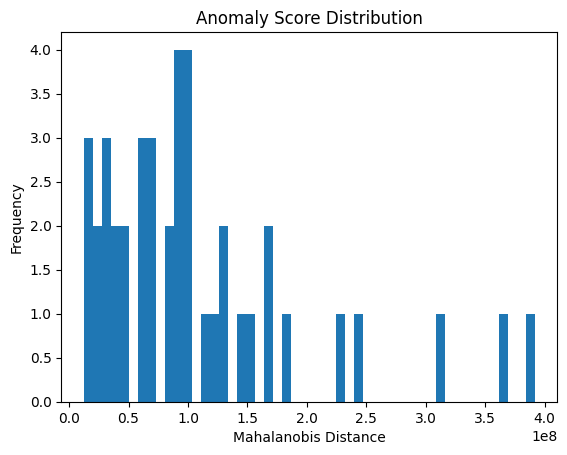

In [42]:
import matplotlib.pyplot as plt
# Optional: visualize distribution
plt.hist(anomaly_scores, bins=50)
plt.axvline(threshold, color="red", linestyle="--")
plt.title("Anomaly Score Distribution")
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Frequency")
plt.show()

In [46]:
import torch
from PIL import Image
import numpy as np
from scipy.spatial import distance
import torchvision.transforms as transforms

# Assuming these variables are already defined and loaded:
# model, device, transform, mean_vector, inv_cov_matrix, threshold

def infer_anomaly(image_path):
    # Load and preprocess image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Extract feature
    with torch.no_grad():
        feat = model(img_tensor).cpu().numpy().squeeze()

    # Compute anomaly score (Mahalanobis distance)
    score = distance.mahalanobis(feat, mean_vector, inv_cov_matrix)

    # Classify based on threshold
    prediction = "Anomalous" if score > threshold else "Normal"

    return score, prediction

# Example usage:
score, pred = infer_anomaly("/kaggle/input/mvtec-ad/bottle/test/broken_large/007.png")
print(f"Anomaly score: {score:.4f}, Prediction: {pred}")


Anomaly score: 95109432.5280, Prediction: Normal


Fastflow


In [7]:
# !pip install torch torchvision
!pip install fastflow
# !pip install matplotlib opencv-python tqdm


ERROR: Could not find a version that satisfies the requirement fastflow (from versions: none)
ERROR: No matching distribution found for fastflow


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt

In [3]:
# FastFlow Normalizing Flow Module
class CouplingLayer(nn.Module):
    def __init__(self, in_channels, hidden_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels // 2, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, in_channels, 3, padding=1)
        )
    
    def forward(self, x, reverse=False):
        x1, x2 = x.chunk(2, dim=1)
        
        if not reverse:
            s_t = self.net(x1)
            s, t = s_t.chunk(2, dim=1)
            s = torch.tanh(s)
            y1 = x1
            y2 = x2 * torch.exp(s) + t
            log_det = s.sum(dim=[1, 2, 3])
            return torch.cat([y1, y2], dim=1), log_det
        else:
            s_t = self.net(x1)
            s, t = s_t.chunk(2, dim=1)
            s = torch.tanh(s)
            y1 = x1
            y2 = (x2 - t) * torch.exp(-s)
            return torch.cat([y1, y2], dim=1)

class FastFlow(nn.Module):
    def __init__(self, input_channels=512, n_coupling_blocks=8):
        super().__init__()
        self.flows = nn.ModuleList([
            CouplingLayer(input_channels) for _ in range(n_coupling_blocks)
        ])
    
    def forward(self, x, reverse=False):
        if not reverse:
            log_det_total = 0
            for flow in self.flows:
                x, log_det = flow(x, reverse=False)
                log_det_total += log_det
            return x, log_det_total
        else:
            for flow in reversed(self.flows):
                x = flow(x, reverse=True)
            return x

# Feature Extractor using ResNet
class FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        import torchvision.models as models
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        
        # Freeze parameters
        for param in self.features.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        return self.features(x)

In [9]:
# MVTEC Dataset
class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split='train', transform=None):
        self.root_dir = Path(root_dir)
        self.category = category
        self.split = split
        self.transform = transform
        
        if split == 'train':
            self.image_dir = self.root_dir / category / 'train' / 'good'
            self.image_paths = list(self.image_dir.glob('*.png'))
        else:
            self.image_dir = self.root_dir / category / 'test'
            self.image_paths = []
            self.labels = []
            
            # Normal images
            good_dir = self.image_dir / 'good'
            if good_dir.exists():
                good_paths = list(good_dir.glob('*.png'))
                self.image_paths.extend(good_paths)
                self.labels.extend([0] * len(good_paths))
            
            # Anomalous images
            for anomaly_dir in self.image_dir.iterdir():
                if anomaly_dir.is_dir() and anomaly_dir.name != 'good':
                    anomaly_paths = list(anomaly_dir.glob('*.png'))
                    self.image_paths.extend(anomaly_paths)
                    self.labels.extend([1] * len(anomaly_paths))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(str(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
        
        if self.split == 'train':
            return image
        else:
            return image, self.labels[idx]

In [10]:
# FastFlow Model
class FastFlowModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = FeatureExtractor()
        self.flow = FastFlow(input_channels=512)
    
    def forward(self, x):
        features = self.feature_extractor(x)
        z, log_det = self.flow(features)
        return z, log_det

# Training function
def train_fastflow(model, train_loader, num_epochs=100, lr=1e-3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, images in enumerate(train_loader):
            images = images.to(device)
            
            # Forward pass
            z, log_det = model(images)
            
            # Compute loss (negative log-likelihood)
            loss = 0.5 * torch.sum(z**2, dim=[1, 2, 3]) - log_det
            loss = loss.mean()
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}')


In [11]:
# Inference function
def compute_anomaly_score(model, image):
    device = next(model.parameters()).device
    model.eval()
    
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        z, log_det = model(image)
        
        # Anomaly score based on likelihood
        anomaly_score = 0.5 * torch.sum(z**2, dim=[1, 2, 3]) - log_det
        
        # Create anomaly map
        anomaly_map = torch.sum(z**2, dim=1, keepdim=True)
        anomaly_map = F.interpolate(anomaly_map, size=(224, 224), mode='bilinear')
        
    return anomaly_score.cpu().numpy(), anomaly_map.squeeze().cpu().numpy()

In [12]:
# Configuration
MVTEC_PATH = "/kaggle/input/mvtec-ad"  # Update this path
CATEGORY = "bottle"  # Choose category: bottle, cable, capsule, etc.
BATCH_SIZE = 8
NUM_EPOCHS = 50

In [13]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [14]:
# Create datasets
train_dataset = MVTecDataset(MVTEC_PATH, CATEGORY, 'train', transform)
test_dataset = MVTecDataset(MVTEC_PATH, CATEGORY, 'test', transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Create model
model = FastFlowModel()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 151MB/s] 


In [15]:
# Train model
print("Training FastFlow...")
train_fastflow(model, train_loader, NUM_EPOCHS)

Training FastFlow...
Epoch 0, Loss: 47510793.0174
Epoch 10, Loss: 15777.3082
Epoch 20, Loss: 14000.1116
Epoch 30, Loss: 11425.2753
Epoch 40, Loss: 10351.9889


Evaluating...
AUC: 0.9905


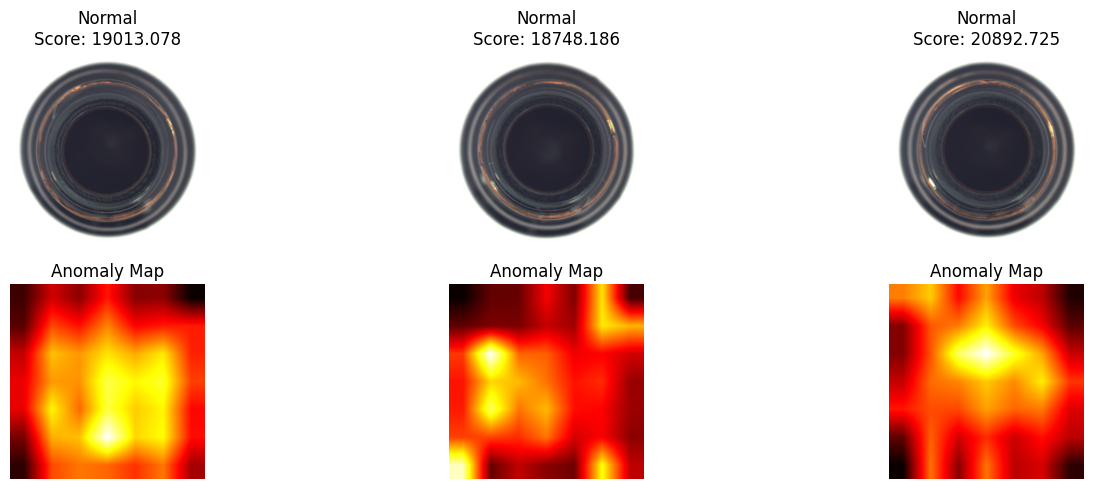

In [19]:
# Evaluate on test set
print("Evaluating...")
model.eval()
scores = []
labels = []

for image, label in test_loader:
    score, anomaly_map = compute_anomaly_score(model, image.squeeze(0))
    scores.append(score[0])
    labels.append(label.item())

# Compute AUC
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(labels, scores)
print(f"AUC: {auc:.4f}")

# Visualize some results
plt.figure(figsize=(15, 5))
for i, (image, label) in enumerate(test_loader):
    if i >= 3:  # Show first 3 test images
        break
        
    score, anomaly_map = compute_anomaly_score(model, image.squeeze(0))
    
    # Original image
    plt.subplot(2, 3, i+1)
    img = image.squeeze(0).permute(1, 2, 0)
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    plt.imshow(torch.clamp(img, 0, 1))
    plt.title(f'{"Anomaly" if label.item() else "Normal"}\nScore: {score[0]:.3f}')
    plt.axis('off')
    
    # Anomaly map
    plt.subplot(2, 3, i+4)
    plt.imshow(anomaly_map, cmap='hot')
    plt.title('Anomaly Map')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
def fastflow_inference(model, image_path, threshold=0.5):
    """
    Simple inference function for FastFlow anomaly detection
    
    Args:
        model: Trained FastFlow model
        image_path: Path to input image
        threshold: Anomaly threshold (optional)
    
    Returns:
        dict: {
            'is_anomaly': bool,
            'anomaly_score': float,
            'anomaly_map': numpy array,
            'image': numpy array (original image)
        }
    """
    
    # Image preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    original_image = np.array(image)
    
    # Transform for model
    input_tensor = transform(image).unsqueeze(0)
    
    # Get device
    device = next(model.parameters()).device
    model.eval()
    
    with torch.no_grad():
        input_tensor = input_tensor.to(device)
        
        # Forward pass
        z, log_det = model(input_tensor)
        
        # Compute anomaly score
        anomaly_score = (0.5 * torch.sum(z**2, dim=[1, 2, 3]) - log_det).item()
        
        # Create anomaly map
        anomaly_map = torch.sum(z**2, dim=1, keepdim=True)
        anomaly_map = torch.nn.functional.interpolate(
            anomaly_map, size=(224, 224), mode='bilinear'
        ).squeeze().cpu().numpy()
        
        # Normalize anomaly map to 0-1
        anomaly_map = (anomaly_map - anomaly_map.min()) / (anomaly_map.max() - anomaly_map.min())
    
    # Determine if anomaly
    is_anomaly = anomaly_score > threshold
    
    return {
        'is_anomaly': is_anomaly,
        'anomaly_score': anomaly_score,
        'anomaly_map': anomaly_map,
        'image': original_image
    }


In [25]:
from PIL import Image
model = FastFlowModel()  # Your trained model
# model.load_state_dict(torch.load('fastflow_model.pth'))  # Load weights

# Run inference
result = fastflow_inference(model, '/kaggle/input/mvtec-ad/bottle/test/contamination/005.png')

print(f"Is Anomaly: {result['is_anomaly']}")
print(f"Anomaly Score: {result['anomaly_score']:.4f}")

Is Anomaly: True
Anomaly Score: 43190.6719


In [1]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 256

# ------------------------
# Dataset Loader
# ------------------------
class MVTECDataset(Dataset):
    def __init__(self, root, transform=None):
        self.img_paths = []
        for root, _, files in os.walk(root):
            for f in files:
                if f.endswith('.png') or f.endswith('.jpg'):
                    self.img_paths.append(os.path.join(root, f))
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, self.img_paths[idx]

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])


In [2]:
class FastFlow(nn.Module):
    def __init__(self, backbone='resnet50', flow_steps=16):
        super().__init__()
        backbone_model = getattr(models, backbone)(pretrained=True)
        self.encoder = nn.Sequential(*list(backbone_model.children())[:-2])  # Output shape: (B, 512, 8, 8)

        self.flows = nn.ModuleList([
            nn.Conv2d(512, 512, 3, padding=1) for _ in range(flow_steps)
        ])

    def extract_features(self, x):
        with torch.no_grad():
            feats = self.encoder(x)
        return feats

    def forward(self, x):
        z = self.extract_features(x)
        log_prob = 0
        for flow in self.flows:
            z = flow(z)
            log_prob += -0.5 * z.pow(2).sum(dim=1)
        anomaly_map = -log_prob
        anomaly_map = F.interpolate(anomaly_map.unsqueeze(1), size=(IMG_SIZE, IMG_SIZE), mode='bilinear')
        return anomaly_map.squeeze(1)


In [3]:
model = FastFlow().to(device)
optimizer = torch.optim.Adam(model.flows.parameters(), lr=1e-4)

train_data = MVTECDataset('/kaggle/input/mvtec-ad/bottle/train', transform=transform)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)

model.train()
for epoch in range(10):
    for imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs = imgs.to(device)
        anomaly_map = model(imgs)
        loss = anomaly_map.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 36.7MB/s]
Epoch 1:   0%|          | 0/27 [00:01<?, ?it/s]


RuntimeError: Given groups=1, weight of size [512, 512, 3, 3], expected input[8, 2048, 8, 8] to have 512 channels, but got 2048 channels instead

In [37]:
def compute_threshold(model, dataloader, multiplier=3.0):
    scores = []
    model.eval()
    with torch.no_grad():
        for imgs, _ in dataloader:
            imgs = imgs.to(device)
            amaps = model(imgs).squeeze().cpu().numpy()
            if amaps.ndim == 2:
                scores.append(amaps.mean())
            else:
                for amap in amaps:
                    scores.append(amap.mean())
    scores = np.array(scores)
    threshold = np.mean(scores) + multiplier * np.std(scores)
    print(f"Computed threshold: {threshold:.4f}")
    return threshold


In [38]:
threshold = compute_threshold(model, train_loader)

Computed threshold: 27.3930


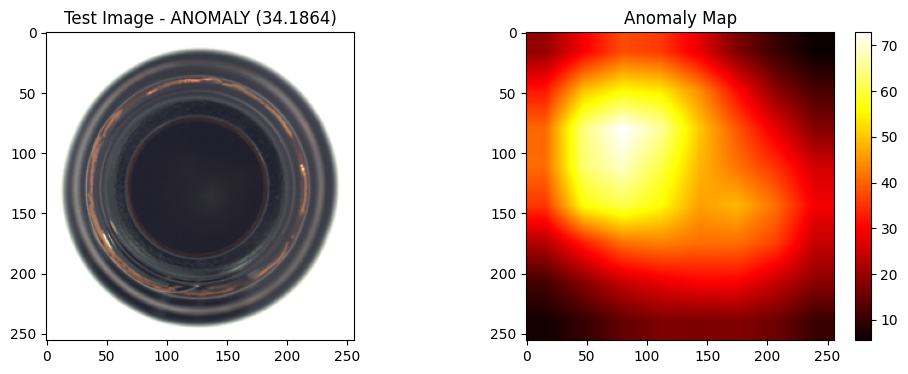

Anomaly Score: 34.1864 | Prediction: ANOMALY


(34.18642, 'ANOMALY')

In [40]:
# def infer(model, img_path):
#     model.eval()
#     img = Image.open(img_path).convert("RGB")
#     img_tensor = transform(img).unsqueeze(0).to(device)

#     with torch.no_grad():
#         anomaly_map = model(img_tensor)
#         anomaly_map = anomaly_map.squeeze().cpu().numpy()

#     img = np.array(img.resize((IMG_SIZE, IMG_SIZE)))

#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 2, 1)
#     plt.imshow(img)
#     plt.title("Test Image")

#     plt.subplot(1, 2, 2)
#     plt.imshow(anomaly_map, cmap='hot')
#     plt.title("Anomaly Map")
#     plt.colorbar()
#     plt.show()
def infer(model, img_path, threshold=threshold):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        anomaly_map = model(img_tensor)
        anomaly_map = anomaly_map.squeeze().cpu().numpy()

    # Simple image-level anomaly score: max or mean of anomaly map
    image_score = anomaly_map.mean()

    # Prediction
    is_anomaly = image_score > threshold
    label = "ANOMALY" if is_anomaly else "NORMAL"

    # Show
    img = np.array(img.resize((IMG_SIZE, IMG_SIZE)))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Test Image - {label} ({image_score:.4f})")

    plt.subplot(1, 2, 2)
    plt.imshow(anomaly_map, cmap='hot')
    plt.title("Anomaly Map")
    plt.colorbar()
    plt.show()

    print(f"Anomaly Score: {image_score:.4f} | Prediction: {label}")
    return image_score, label

# Example use:
infer(model, '/kaggle/input/mvtec-ad/bottle/test/good/010.png')


EfficientAD

In [4]:
pip install torchvision einops


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 28.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-1

In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 224

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

class MVTecDataset(Dataset):
    def __init__(self, root):
        self.paths = [os.path.join(root, f) for f in os.listdir(root)
                      if f.endswith('.png') or f.endswith('.jpg')]
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return transform(img), self.paths[idx]


In [8]:
class Teacher(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.efficientnet_b0(pretrained=True)
        self.features = nn.Sequential(*list(base.features.children()))
    def forward(self, x):
        with torch.no_grad():
            return self.features(x)

class Student(nn.Module):
    def __init__(self, in_channels=1280, out_channels=1280):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 256, 1),
            nn.ReLU(),
            nn.Conv2d(256, out_channels, 1)
        )
    def forward(self, x):
        return self.net(x)


In [9]:
teacher = Teacher().to(device).eval()
student = Student().to(device)
optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)

train_loader = DataLoader(MVTecDataset("/kaggle/input/mvtec-ad/bottle/test/good"), batch_size=8, shuffle=True)

for epoch in range(10):
    student.train()
    for imgs, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        imgs = imgs.to(device)
        with torch.no_grad():
            t_feat = teacher(imgs)[-1]  # Use last feature map (e.g., [B, 320, 7, 7])
        s_feat = student(t_feat)

        loss = F.mse_loss(s_feat, t_feat)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


Epoch 10: 100%|██████████| 3/3 [00:00<00:00,  4.28it/s]


In [10]:
def infer(img_path, threshold=0.02):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        t_feat = teacher(img_tensor)[-1]
        s_feat = student(t_feat)
        dist = F.mse_loss(s_feat, t_feat, reduction='none')
        score = dist.mean().item()

    label = "ANOMALY" if score > threshold else "NORMAL"
    print(f"{img_path} | Score: {score:.4f} | {label}")
    return score, label


In [12]:
def compute_threshold(dataloader):
    scores = []
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        with torch.no_grad():
            t_feat = teacher(imgs)[-1]
            s_feat = student(t_feat)
            dist = F.mse_loss(s_feat, t_feat, reduction='none')

            if dist.ndim == 4:
                batch_scores = dist.mean(dim=[1, 2, 3])
            elif dist.ndim == 2:
                batch_scores = dist.mean(dim=1)
            else:
                batch_scores = dist.mean().unsqueeze(0)

            scores.extend(batch_scores.cpu().numpy())
    scores = np.array(scores)
    threshold = np.mean(scores) + 3 * np.std(scores)
    print(f"Computed threshold: {threshold:.4f}")
    return threshold


In [17]:
threshold = compute_threshold(train_loader)

Computed threshold: 0.0823


In [19]:
infer('/kaggle/input/mvtec-ad/bottle/test/broken_small/002.png',threshold)

/kaggle/input/mvtec-ad/bottle/test/broken_small/002.png | Score: 0.2001 | ANOMALY


(0.2000778168439865, 'ANOMALY')

In [20]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt

def evaluate_model(test_root, threshold):
    test_data = []
    y_true = []
    y_scores = []

    for cls in os.listdir(test_root):
        cls_path = os.path.join(test_root, cls)
        label = 0 if cls == 'good' else 1

        for img_file in os.listdir(cls_path):
            if not (img_file.endswith('.png') or img_file.endswith('.jpg')):
                continue
            img_path = os.path.join(cls_path, img_file)
            img = Image.open(img_path).convert("RGB")
            img_tensor = transform(img).unsqueeze(0).to(device)

            with torch.no_grad():
                t_feat = teacher(img_tensor)[-1]
                s_feat = student(t_feat)
                dist = F.mse_loss(s_feat, t_feat, reduction='none')
                score = dist.mean().item()

            test_data.append(img_path)
            y_true.append(label)
            y_scores.append(score)

    # Binarize predictions
    y_pred = [1 if s > threshold else 0 for s in y_scores]

    # Compute metrics
    roc_auc = roc_auc_score(y_true, y_scores)
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"])

    print("📊 ROC AUC Score:", roc_auc)
    print("\n🧾 Classification Report:\n", report)
    print("📉 Confusion Matrix:\n", cm)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
    plt.plot([0,1],[0,1],'--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


📊 ROC AUC Score: 0.9880952380952381

🧾 Classification Report:
               precision    recall  f1-score   support

      Normal       0.90      0.95      0.93        20
     Anomaly       0.98      0.97      0.98        63

    accuracy                           0.96        83
   macro avg       0.94      0.96      0.95        83
weighted avg       0.96      0.96      0.96        83

📉 Confusion Matrix:
 [[19  1]
 [ 2 61]]


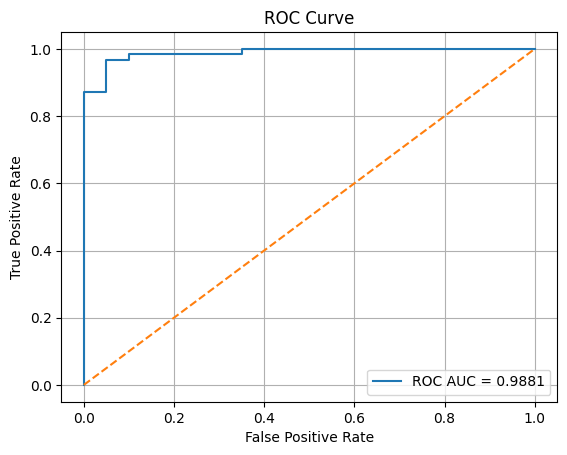

In [21]:
test_root = "/kaggle/input/mvtec-ad/bottle/test"
evaluate_model(test_root, threshold)
